In [1]:
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import tensorflow_datasets as tfds

from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras import layers
# from sklearn import preprocessing
# Make numpy values easier to read.
# np.set_printoptions(precision=3, suppress=True)

# physical_devices = tf.config.list_physical_devices("gpu")
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.backend.set_floatx('float64')
tf.compat.v1.enable_eager_execution()

2023-01-27 19:29:06.127772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# GPUs Available:  0


2023-01-27 19:29:07.320397: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-01-27 19:29:07.320424: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vn
2023-01-27 19:29:07.320428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vn
2023-01-27 19:29:07.320583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.108.3
2023-01-27 19:29:07.320599: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.108.3
2023-01-27 19:29:07.320604: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.108.3


In [2]:
# preprocessing of data

leakage_train_100 = pd.read_csv("leakage_dataset_train_100.csv")
leakage_train_1000 = pd.read_csv("leakage_dataset_train_1000.csv")
leakage_val_1000 = pd.read_csv("leakage_dataset_validation_1000.csv")

# leakage_train_100.head()
# leakage_val_1000.head()

#create two output arrays
def format_output(data):
    data = data.copy()
    y1 = data.pop('y1')
    y1 = np.array(y1)
    y2 = data.pop('y2')
    y2 = np.array(y2)
    return y1, y2

X_train = leakage_train_100.iloc[:,2:].to_numpy()
Y_train = leakage_train_100.iloc[:,:2]

#splitting of x and y variable
# X_train = leakage_train_1000.iloc[:,2:].to_numpy()
# Y_train = leakage_train_1000.iloc[:,:2]

num_rows, num_cols = X_train.shape

X_validation = leakage_val_1000.iloc[:,2:].to_numpy()
Y_validation = leakage_val_1000.iloc[:,:2]

# scX = preprocessing.StandardScaler()
# X_train = scX.fit_transform(X_train)
# X_validation = scX.transform(X_validation)

# stY = preprocessing.StandardScaler()
# Y_train = stY.fit_transform(Y_train)
# Y_validation = stY.transform(Y_validation)

# Y_train = pd.DataFrame(Y_train, columns = ['y1','y2'])
# Y_validation = pd.DataFrame(Y_validation, columns = ['y1','y2'])

y1_train, y2_train = format_output(Y_train)
y1_validation, y2_validation = format_output(Y_validation)

Y_train = Y_train.to_numpy()
Y_validation = Y_validation.to_numpy()

In [3]:
tf.random.set_seed(42) 

# NN architechture - keras Functional API
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(4, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
dense2_2 = tf.keras.layers.Dense(1, name = 'y2')

x=dense1(inputs)

outputs1=dense2_1(x)
outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name = 'leakge_functional_model')

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.mean_squared_error,
              metrics = ['accuracy']
)

y = {
    "y1" : y1_train,
    "y2" : y2_train
}

y_valid = {
    "y1" : y1_validation,
    "y2" : y2_validation
}


model.fit(X_train, y=y, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation, y_valid))

predictions = model.predict(X_validation)

# even for a primilinary result, the loss is pretty good

Model: "leakge_functional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            20          ['input_1[0][0]']                
                                                                                                  
 y1 (Dense)                     (None, 1)            5           ['dense[0][0]']                  
                                                                                                  
 y2 (Dense)                     (None, 1)            5           ['dense[0][0]']                  
                                                                            

2023-01-27 19:29:07.531369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


20/20 - 1s - loss: 0.6321 - y1_loss: 0.3171 - y2_loss: 0.3150 - y1_accuracy: 0.0000e+00 - y2_accuracy: 0.0000e+00 - val_loss: 0.5154 - val_y1_loss: 0.2170 - val_y2_loss: 0.2983 - val_y1_accuracy: 0.0000e+00 - val_y2_accuracy: 0.0000e+00 - 796ms/epoch - 40ms/step
Epoch 2/5
20/20 - 0s - loss: 0.3376 - y1_loss: 0.1286 - y2_loss: 0.2090 - y1_accuracy: 0.0000e+00 - y2_accuracy: 0.0000e+00 - val_loss: 0.1965 - val_y1_loss: 0.0464 - val_y2_loss: 0.1500 - val_y1_accuracy: 0.0000e+00 - val_y2_accuracy: 0.0000e+00 - 181ms/epoch - 9ms/step
Epoch 3/5
20/20 - 0s - loss: 0.1368 - y1_loss: 0.0489 - y2_loss: 0.0879 - y1_accuracy: 0.0000e+00 - y2_accuracy: 0.0000e+00 - val_loss: 0.0910 - val_y1_loss: 0.0246 - val_y2_loss: 0.0664 - val_y1_accuracy: 0.0000e+00 - val_y2_accuracy: 0.0000e+00 - 159ms/epoch - 8ms/step
Epoch 4/5
20/20 - 0s - loss: 0.0737 - y1_loss: 0.0382 - y2_loss: 0.0355 - y1_accuracy: 0.0000e+00 - y2_accuracy: 0.0000e+00 - val_loss: 0.0791 - val_y1_loss: 0.0561 - val_y2_loss: 0.0229 - val_

rmse of y1:  0.15185328891590244
rmse of y2:  0.18332420326238527


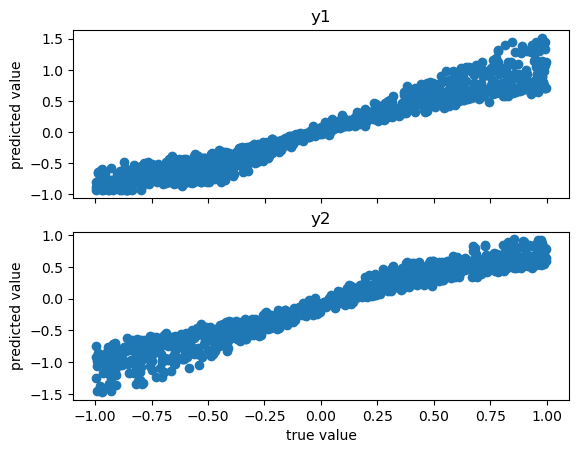

In [4]:
def prediction_accuracy(predictions, y1_validation, y2_validation): 
    y1 = predictions[0]
    y2 = predictions[1]
    fig, axs = plt.subplots(2)
    # print(y1_validation.shape, y1.shape)
    # print(y2_validation.shape, y2.shape)
    # fig.suptitle('')
    axs[0].scatter(y1_validation, y1)
    axs[0].set_title('y1')
    axs[1].scatter(y2_validation, y2)
    axs[1].set_title('y2')
    for ax in axs.flat:
        ax.set(xlabel='true value', ylabel='predicted value')
    for ax in axs.flat:
        ax.label_outer()

    print("rmse of y1: ", mean_squared_error(y1_validation, y1, squared=False))
    print("rmse of y2: ", mean_squared_error(y2_validation, y2, squared=False))

prediction_accuracy(predictions, y1_validation, y2_validation)

In [5]:
print(model.layers[1].weights)

[<tf.Variable 'dense/kernel:0' shape=(4, 4) dtype=float64, numpy=
array([[-0.79123269, -0.09097646, -1.15797728, -1.05542581],
       [ 1.84875802, -0.60206185, -0.36299811, -0.34583034],
       [ 1.87608281, -1.30350304, -0.17539303,  1.68429842],
       [-1.38289712, -0.93980937, -1.20103749,  1.15138675]])>, <tf.Variable 'dense/bias:0' shape=(4,) dtype=float64, numpy=array([ 0.31130177, -0.60051676, -0.60050567,  0.09357843])>]


In [6]:
# data Augmentation
# Requires cleaning up

def rotation_matrix(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    return R

def Augmentation_clock(x,y):

    x = x.copy()
    y = y.copy()
    # print(y)
    y_aug = np.transpose(np.matmul(rotation_matrix(-90), np.transpose(y)))
    # print(y_aug)

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    # print(x0.shape)

    x[:,0] = x3
    x[:,1] = x0
    x[:,2] = x1
    x[:,3] = x2
 
    return x,y_aug


def Augmentation_flip(x,y):
    x = x.copy()
    y = y.copy()
    x = np.flip(x, axis=1)
    y[:,1] = -1 * y[:,1]
    return x,y

def Augmentation_anticlock(x,y):

    x = x.copy()
    y = y.copy()
    y_aug = np.transpose(np.matmul(rotation_matrix(90), np.transpose(y)))

    temp = x.copy()
    x0 = temp[:,0]
    x1 = temp[:,1]
    x2 = temp[:,2]
    x3 = temp[:,3]

    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x0
 
    return x,y_aug

# # test inputs
# X_train = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# # print(X_train)
# Y_train = np.array([[15,16], [17,18], [19,20]])
# num_rows, num_cols = X_train.shape

def data_augmentation(x,y):
    x_aug1,y_aug1 = Augmentation_clock(x, y)
    x_aug2,y_aug2 = Augmentation_clock(x_aug1,y_aug1)
    x_aug3,y_aug3 = Augmentation_clock(x_aug2,y_aug2)
    x_aug4,y_aug4 = Augmentation_flip(x_aug3,y_aug3)
    x_aug5,y_aug5 = Augmentation_clock(x_aug4,y_aug4)
    x_aug6,y_aug6 = Augmentation_clock(x_aug5,y_aug5)
    x_aug7,y_aug7 = Augmentation_clock(x_aug6,y_aug6)
    X_train_Aug = np.concatenate((x, x_aug1, x_aug2, x_aug3, x_aug4, x_aug5, x_aug6, x_aug7))
    Y_train_Aug = np.concatenate((y, y_aug1, y_aug2, y_aug3, y_aug4, y_aug5, y_aug6, y_aug7))

    return X_train_Aug, Y_train_Aug

X_train_Aug, Y_train_Aug = data_augmentation(X_train, Y_train)
X_validation_Aug, Y_validation_Aug = data_augmentation(X_validation, Y_validation)

In [7]:
# tf.random.set_seed(42) 

# Model trained on Augmented dataset
# Now we have one input layer, 1 hidden layer and 2 output layer - both connected to hidden layer
# Thinking of adding a normalization layer or doing normalization before training
# inputs = tf.keras.layers.Normalization(input_shape=[4,], axis=None)
inputs = tf.keras.Input(shape=(4,))
dense1 = tf.keras.layers.Dense(4, activation='relu')
# dense2_1 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y1')
# dense2_2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'y2')

dense2_1 = tf.keras.layers.Dense(1, name = 'y1')
dense2_2 = tf.keras.layers.Dense(1, name = 'y2')

x=dense1(inputs)

outputs1=dense2_1(x)
outputs2=dense2_2(x)

model = tf.keras.Model(inputs=inputs, outputs=[outputs1, outputs2], name = 'leakge_aug_functional_model')

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss=tf.keras.losses.mean_squared_error,
              metrics = ['accuracy']
)

y_aug = {
    "y1" : Y_train_Aug[:,0],
    "y2" : Y_train_Aug[:,1]
}

y_aug_valid = {
    "y1" : Y_validation_Aug[:,0],
    "y2" : Y_validation_Aug[:,1]
}


model.fit(X_train_Aug, y=y_aug, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation_Aug, y_aug_valid))

predictions = model.predict(X_validation_Aug)

# even for a primilinary result, the loss is pretty good

Model: "leakge_aug_functional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4)            20          ['input_2[0][0]']                
                                                                                                  
 y1 (Dense)                     (None, 1)            5           ['dense_1[0][0]']                
                                                                                                  
 y2 (Dense)                     (None, 1)            5           ['dense_1[0][0]']                
                                                                        

rmse of y1:  0.526000245001927
rmse of y2:  0.41841160626383406


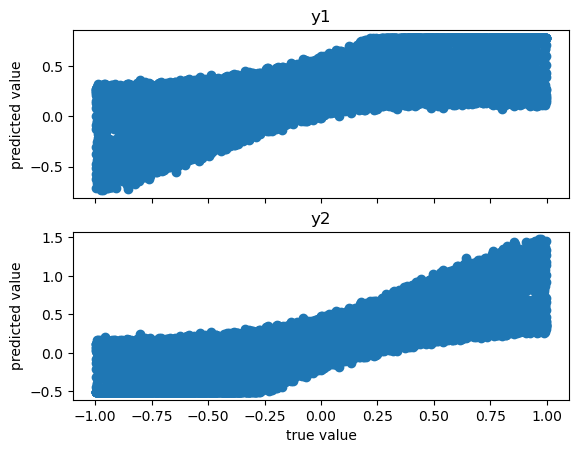

In [8]:
prediction_accuracy(predictions, Y_validation_Aug[:,0], Y_validation_Aug[:,1])

In [14]:
# Equivariance NN with subclassing API
# These function make use of the subclassing Api and custom layer functionality of tensorflow
# experiment

class Hidden_layer(layers.Layer):
    def __init__(self, units):
        super(Hidden_layer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="b", shape=(self.units,), initializer="zeros", trainable=False,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class Output_layer(layers.Layer):
    def __init__(self, units):
        super(Output_layer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            name="w",
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="b", shape=(self.units,), initializer="zeros", trainable=False,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

class MyReLU(layers.Layer):
    def __init__(self):
        super(MyReLU, self).__init__()

    def call(self, x):
        return tf.math.maximum(x, 0)

class MyModel(keras.Model):  # model.fit, model.evalute, model.predict
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = Hidden_layer(4)
        self.dense2_1 = Output_layer(1)
        self.dense2_2 = Output_layer(1)
        self.relu = MyReLU()

    def call(self, x):
        x = self.relu(self.dense1(x))
        return {"y1" :self.dense2_1(x),"y2" : self.dense2_2(x)}
        # return self.dense2_1(x), self.dense2_2(x)

    def build_graph(self):
        x = tf.keras.layers.Input(shape=(4))
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

model = MyModel()
model.build_graph().summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
              loss={
                    'y1': 'mse',
                    'y2': 'mse'
                    },
              metrics = ['accuracy']
)

model.fit(X_train, y=y, epochs=5, batch_size=5, verbose=2, validation_data=(X_validation, y_valid))


# a = tf.Variable(1., name='a', trainable=True)
# b = tf.Variable(1., name='b', trainable=True)
# c = tf.Variable(1., name='c', trainable=True)
# w = [[a, b, c, b], [b, a, b, c], [c, b, a, b], [b, c, b, a]]

# x = tf.constant([[1., 2., 3., 4.]])
# print(x)
# with tf.GradientTape(persistent=True) as tape:
#     y = x @ w
#     loss = y
# print(*tape.gradient(loss, w), sep='\n')


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 hidden (Hidden)                (None, 4)            20          ['input_5[0][0]']                
                                                                                                  
 my_re_lu_2 (MyReLU)            (None, 4)            0           ['hidden[0][0]']                 
                                                                                                  
 hidden_1 (Hidden)              (None, 1)            5           ['my_re_lu_2[0][0]']             
                                                                                            

32/32 [==============================] - 0s 987us/step
rmse of y1:  0.17134660759527337
rmse of y2:  0.11942595764740209


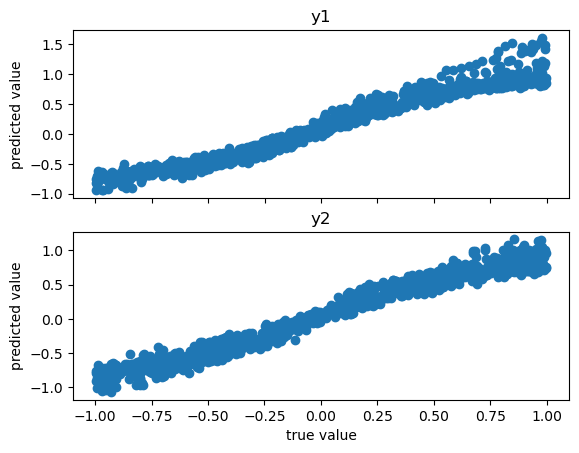

In [15]:

predictions = (model.predict(X_validation))
h1 = predictions["y1"]
h2 = predictions["y2"]
predictions = np.concatenate((h1, h2), axis = 1).transpose()
# print(predictions[0].shape, Y_validation[:,0].shape)
prediction_accuracy(predictions, Y_validation[:,0], Y_validation[:,1])


In [11]:
# failed experiment with Functional API

# from keras.models import Model
# from keras.layers import Dense, Input


# def base_model(inputs):
#     x= Dense(128, activation='relu')(inputs)
#     x= Dense(128, activation='relu')(x)
#     return x

# def final_model(inputs):
#     x = base_model(inputs)
#     y1 = Dense(units='1', name='y1')(x)
#     y2 = Dense(units = '1', name = 'y2')(x)
#     model = Model(inputs=inputs, outputs = [y1, y2])
    
#     return model

# inputs = tf.keras.layers.Input(shape=(4,))
# model = final_model(inputs)

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
#               loss=tf.keras.losses.mean_absolute_error,
#               metrics = ['mae'])
# y = {
#     "y1" : y1_train,
#     "y2" : y2_train
# }

# history = model.fit(X_train, y, epochs=400)